In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer




# Проект 5. Компьютер говорит «Нет» 

##### Вам предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

Описания полей client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

##### Цель: построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента.

In [3]:
#загрузим данные
train = pd.read_csv('../input/sf-dst-scoring/train.csv')
test = pd.read_csv('../input/sf-dst-scoring/test.csv')
submission = pd.read_csv('../input/sf-dst-scoring/sample_submission.csv')
#data = data.drop('app_date',axis=1)

In [4]:
test['default'] = 0 # заполняем признак нулями
test['train'] = 0 # указываем, что записи не принадлежат датасету train
train['train'] = 1 # указываем, что записи принадлежат датасету train
data = pd.concat([train, test], ignore_index=True) # объединяем датасеты в один

Для тестирования модели мы данные в выборке data разделим на test и train, но для начала проведем предобработку и разведывательный анализ данных

### Проведем разведывательный анализ данных и обработаем признаки

In [5]:
# посмотрим на данные
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [6]:
#посмотрим на колонки, которые есть в датасете, пропущенные значения и общую статистику 
display(data.info())
display(data.describe())
display(data.describe(include = ['object']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

None

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.085086,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.279010,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


,app_date,education,sex,car,car_type,foreign_passport
count,110148,109670,110148,110148,110148,110148
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1491,57998,61836,74290,89140,93721


Как видим, пропуски есть только в столбце <span style="color: green;">education</span>. Посмотрим на их количество: 

In [7]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
train                 0
dtype: int64

Всего в колонке education 307 пропусков, что очень мало. Для того чтобы их заполнить, посмотрим на структуру этой колонки при помощи гистограммы: 

<AxesSubplot:>

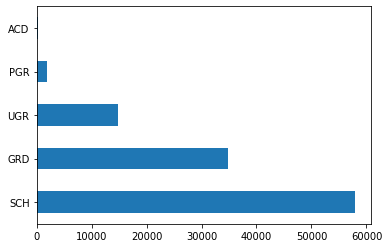

In [8]:
data['education'].value_counts().plot.barh()

По результатам видим, что education - это категориальная переменная, в которой присутствуют разные ступени образования - School, Graduate, Undergradute, Postgraduate, и Acedemic. Поскольку это категориальная переменная, пропуски лучше всего заполнить значением моды, а именно School. Сразу же можно преобразовать строковые значения в числовые. 

In [9]:
data['education'] = data['education'].fillna(data['education'].mode()[0]) #Заполняем пропуски
data.isna().sum() # Проверяем нет ли больше пропусков

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
train               0
dtype: int64

In [10]:
# Создадим словарь для преобразования education
education_dict = {'SCH':0, 'UGR':1, 'GRD':2, 'PGR':3, 'ACD':4} #здесь важно сохранить правильный порядок
data['education'] = data['education'].apply(lambda x: education_dict[x])

In [11]:
data['education'] #Проверяем, произошла ли замена. Как видим, все ок

0         0
1         0
2         0
3         0
4         2
         ..
110143    0
110144    2
110145    2
110146    1
110147    0
Name: education, Length: 110148, dtype: int64

Стоит проверить нескольно переменных, которых не было в базовом датасете на платформе, а именно: 

<ul>sna - связь заемщика с клиентами банка</ul>

<ul>first_time - давность наличия информации о заемщике</ul>

<ul>score_bki - скоринговый балл по данным из БКИ</ul>

<ul>region_rating - рейтинг региона</ul>

<ul>app_date - дата подачи заявки</ul>

In [12]:
data['sna'].value_counts() # категориальная переменная

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

In [13]:
data['first_time'].value_counts() # категориальная переменная

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

In [14]:
data['score_bki'] # числовая переменная

0        -2.008753
1        -1.532276
2        -1.408142
3        -2.057471
4        -1.244723
            ...   
110143   -1.744976
110144   -2.293781
110145   -0.940752
110146   -1.242392
110147   -1.507549
Name: score_bki, Length: 110148, dtype: float64

In [15]:
data['region_rating'] #скорее категориальная переменная, (преобразовать???)

0         50
1         50
2         80
3         50
4         60
          ..
110143    50
110144    60
110145    50
110146    80
110147    50
Name: region_rating, Length: 110148, dtype: int64

In [16]:
#преобразуем в более привычный формат
data['app_date'] = data['app_date'].apply(lambda x: x[0:2]+'-'+x[2:5]+'-'+x[5:9]) 

In [17]:
data['app_date'] = pd.to_datetime(data['app_date']) # Преобразуем в datetime

In [18]:
data['app_date'].dt.year.value_counts() #как видим, информация только за 2014 год

2014    110148
Name: app_date, dtype: int64

In [19]:
#Преобразуем datetime в месяца: 
data.app_date.dt.month.value_counts(normalize = True)

3    0.286859
2    0.246005
4    0.238461
1    0.228674
Name: app_date, dtype: float64

Как видим, у нас представлено всего 4 месяца - январь, февраль, март и апрель, и они распределены почти равномерно. Чуть больше заявок было подано в марте, и чуть меньше в январе

<AxesSubplot:>

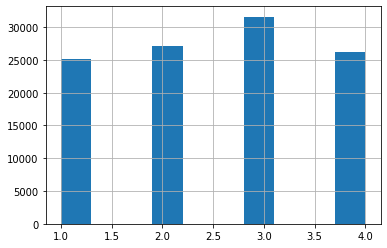

In [20]:
data.app_date.dt.month.hist()

<AxesSubplot:>

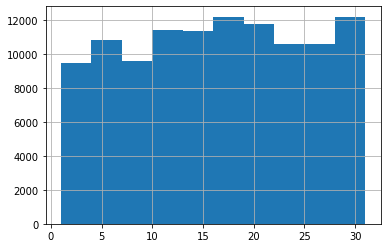

In [21]:
# Посмотрим на распределение поданных заявок в определенные дни. Как видим, больше всего заявок подаются в конце месяца
data.app_date.dt.day.hist()

Рассмотрим коробки с усами

In [22]:
data['app_month'] = data['app_date'].dt.month

In [23]:
#Распределение дефолтных клиентов для подавших заявку в январе
data[(data['app_month']==1) & (data['train']==1)].default.value_counts(normalize=True) 

0    0.857658
1    0.142342
Name: default, dtype: float64

In [24]:
#Распределение дефолтных клиентов для подавших заявку в феврале
data[(data['app_month']==2) & (data['train']==1)].default.value_counts(normalize=True)

0    0.867373
1    0.132627
Name: default, dtype: float64

In [25]:
#Распределение дефолтных клиентов для подавших заявку в марте
data[(data['app_month']==3) & ((data['train']==1))].default.value_counts(normalize=True)

0    0.872462
1    0.127538
Name: default, dtype: float64

In [26]:
#Распределение дефолтных клиентов для подавших заявку в апреле
data[(data['app_month']==4) & ((data['train']==1))].default.value_counts(normalize=True)

0    0.894079
1    0.105921
Name: default, dtype: float64

<AxesSubplot:>

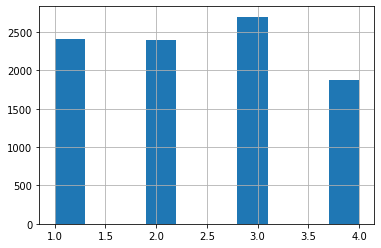

In [27]:
data[(data['default']==1) & (data['train']==1)].app_month.hist() #Количество дефолтных клиентов по месяцам поданных заявок

<AxesSubplot:>

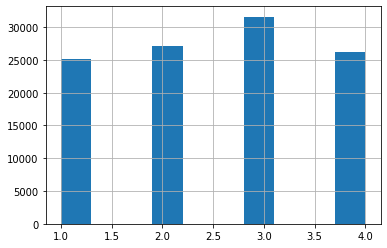

In [28]:
data.app_month.hist() #Количество поданных заявок

Судя по тому что процентное соотношение дефолтных клиентов с января до апреля падает, вполне возможно что такие цифры коррелируют с "временной переменной", а именно для подсчета дефолтности было больше времени с января, чем с апреля, поэтому вполне возможно что этот показатель никак не влияет. Это не совсем категориальная переменная, но можно попробовать ее включить.

In [29]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_month
76005,81951,2014-03-30,0,F,45,N,N,0,0,-1.573417,...,50,1,2,17000,1,4,N,0,0,3
89710,37895,2014-02-14,0,F,25,Y,N,0,1,-1.397724,...,60,1,1,33000,1,3,N,0,0,2
96065,64963,2014-03-14,0,F,31,N,N,0,0,-1.123455,...,40,1,2,22000,1,2,N,0,0,3
88272,32979,2014-02-09,2,F,61,N,N,0,0,-2.592782,...,50,2,3,8000,4,1,N,0,0,2
17545,92275,2014-04-08,0,F,65,N,N,0,0,-0.938321,...,40,2,3,20000,1,4,N,1,1,4


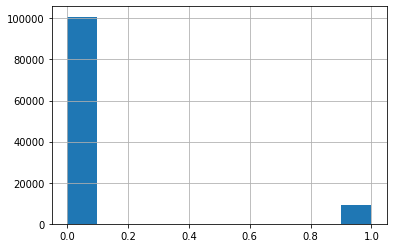

In [30]:
# посмотрим количество недобросовестных клиентов
data.default.hist();

#### Разделим колонки по категориям: числовые, категориальные, бинарные

In [31]:
num_cols = ['age','decline_app_cnt','bki_request_cnt', 'income', 'score_bki'] #числовые переменные
cat_cols = ['education','work_address', 'home_address', 'sna', 'first_time', 'app_month', 'region_rating'] #категориальные переменные
bin_cols = ['sex','car','car_type','foreign_passport', 'good_work'] #бинарные переменные

#### Рассмотрим числовые признаки

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


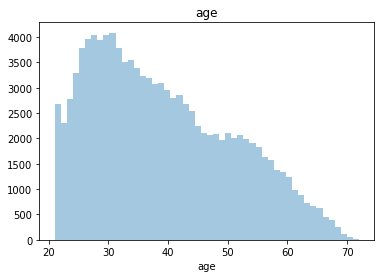

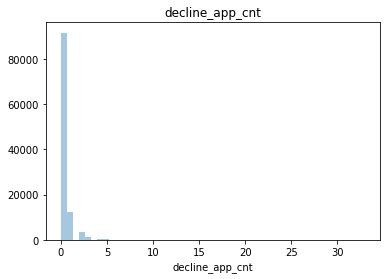

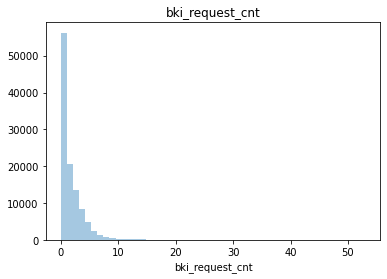

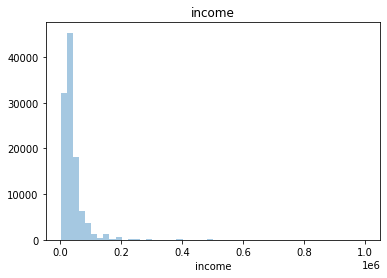

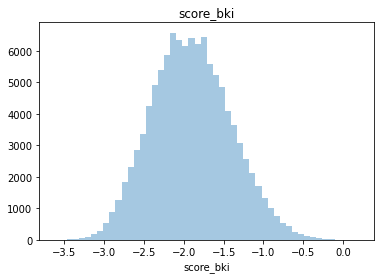

In [32]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

Большинство переменных (кроме <span style="color: green;">score_bki</span>) распределены ненормально, поэтому их можно попробовать прологарифмировать для нормализации. 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


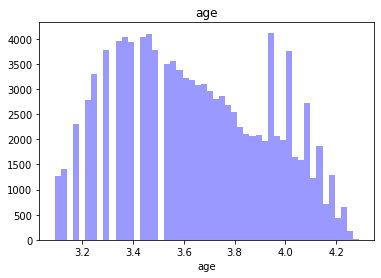

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


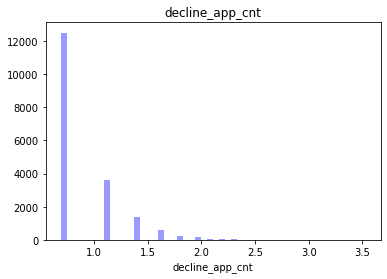

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


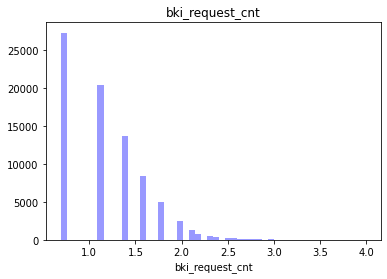

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


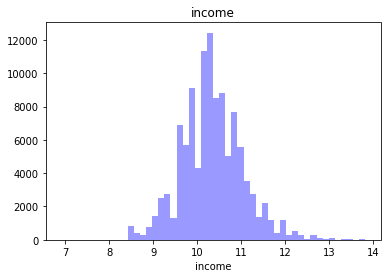

In [33]:
# логарифмируем остальные числовые переменные
log_num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in log_num_cols:
    #зачем к логарифму добавляем 1 - чтобы если в df[i] был 0, то натуральный логарифм нуля - минус бесконечность
    data[i] = np.log(data[i]+1)
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

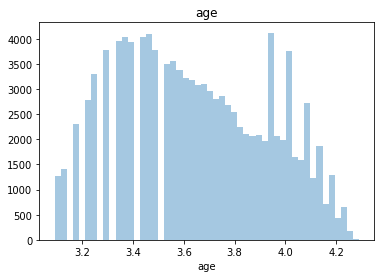

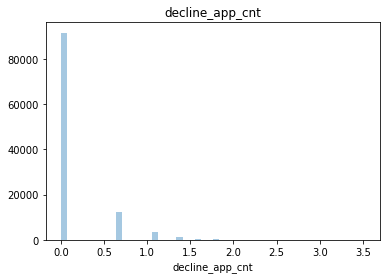

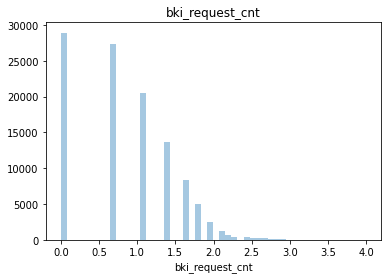

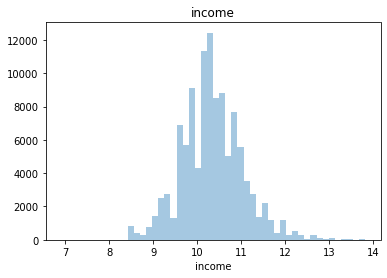

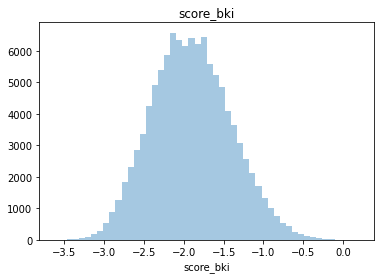

In [34]:
# проверим, что получилось и перезапишем список с числовыми признаками
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

Признаки <span style="color: green;">age</span> и <span style="color: green;">income</span> стали ближе к нормальному распределению, для <span style="color: green;">decline_app_cnt</span>decline_app_cnt и <span style="color: green;">bki_request_cnt</span>bki_request_cnt нормальности добиться не удалось, хотя их распределения все равно улучшились

In [35]:
# Для удобства выделим отдельно тренировочный сет: 
data_train = data[data['train']==1]
data_train


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_month
0,25905,2014-02-01,0,M,4.143135,Y,Y,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,N,0,1,2
1,63161,2014-03-12,0,F,4.094345,N,N,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,N,0,1,3
2,25887,2014-02-01,0,M,3.258097,Y,N,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,Y,0,1,2
3,16222,2014-01-23,0,F,3.988984,N,N,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,N,0,1,1
4,101655,2014-04-18,2,M,3.891820,N,N,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,Y,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04,2,F,3.828641,N,N,0.000000,0,-1.792064,...,50,1,2,9.741027,4,4,N,0,1,3
73795,76821,2014-03-24,0,M,3.737670,Y,Y,0.000000,0,-2.058029,...,50,2,2,11.156265,1,4,N,0,1,3
73796,103695,2014-04-22,0,M,3.465736,N,N,0.000000,0,-1.512635,...,80,2,3,10.714440,2,2,N,0,1,4
73797,861,2014-01-04,0,F,3.401197,N,N,0.000000,1,-1.479334,...,50,1,3,9.472782,2,3,N,1,1,1


<AxesSubplot:>

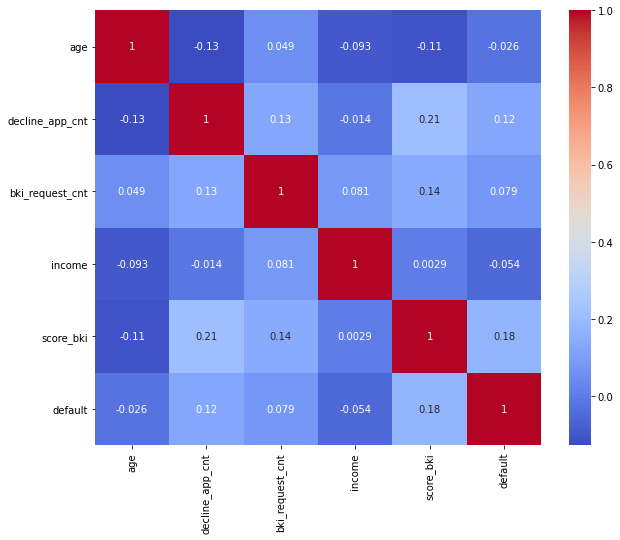

In [36]:
# построим матрицу корреляций для числовых признаков в тренировочной выборке
plt.figure(figsize=(10,8))
sns.heatmap(data_train[(num_cols+['default'])].corr(), cmap='coolwarm', annot=True)

In [37]:
data_train[num_cols+['default']].corr()

,age,decline_app_cnt,bki_request_cnt,income,score_bki,default
age,1.000000,-0.127734,0.049327,-0.092586,-0.109971,-0.026119
decline_app_cnt,-0.127734,1.000000,0.125163,-0.013868,0.210090,0.124027
bki_request_cnt,0.049327,0.125163,1.000000,0.081019,0.139622,0.078501
income,-0.092586,-0.013868,0.081019,1.000000,0.002860,-0.053871
score_bki,-0.109971,0.210090,0.139622,0.002860,1.000000,0.175369
default,-0.026119,0.124027,0.078501,-0.053871,0.175369,1.000000


Исходя из матрицы корреляций можно заметить, что взаимосвязь между переменными слабая, наибольшее значение наблюдается между переменными <span style="color: green;">score_bki</span> и <span style="color: green;">decline_app_cnt</span> - корреляция составляет 0.21. При чем эти переменные оказывают наибольшее влияние (если рассматривать линейную зависимость) на зависимую переменную: <span style="color: green;">score_bki</span> (0.17), <span style="color: green;">decline_app_cnt</span> (0.12). 

<AxesSubplot:>

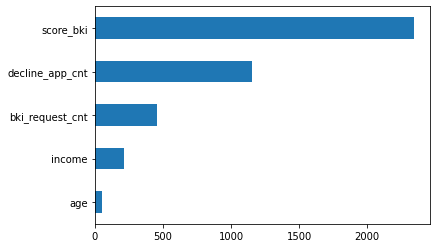

In [38]:
# Оценим значимость непрерывных переменных
imp_num = Series(f_classif(data_train[num_cols], data_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### По значимости (функция <span style="color: purple;">**imp_num**</span>) наиболее значимымы являются все те же переменные <span style="color: green;">score_bki</span> и <span style="color: green;">decline_app_cnt</span>

#### Рассмотрим бинарные переменные

In [39]:
# Для преобразования бинарных признаков используем LabelEncoder, 
# который переводит бинарные признаки в числовой формат

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_month
0,25905,2014-02-01,0,1,4.143135,1,1,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0,1,2
1,63161,2014-03-12,0,0,4.094345,0,0,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0,1,3
2,25887,2014-02-01,0,1,3.258097,1,0,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0,1,2
3,16222,2014-01-23,0,0,3.988984,0,0,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,0,0,1,1
4,101655,2014-04-18,2,1,3.891820,0,0,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,1,0,1,4


#### Рассмотрим категориальные переменные

In [40]:
# Для категориальных признаков мы будем использовать OneHotEncoder в тренировочной выборке
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

In [41]:
# Проверим, что категориальные признаки правильно сгенерированы:
X_cat.shape

(110148, 30)

<AxesSubplot:>

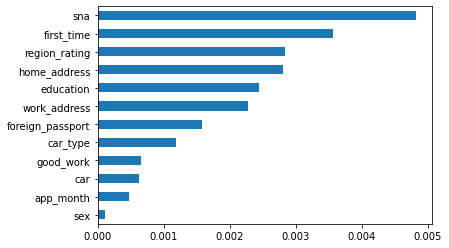

In [42]:
# Посмотрим на значимость категориальных признаков (тренировочная выборка)
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наименее значимые признаки для формирования дефолтных клиентов - это <span style="color: green;">sex</span>, <span style="color: green;">app_month</span>, <span style="color: green;">car</span> и <span style="color: green;">good_work</span>.

In [43]:
# попробуем стандартизировать числовые признаки в тренировочной выборке: 
X_num = StandardScaler().fit_transform(data[num_cols].values)

In [44]:
data.head()
data_train = data[data['train']==1]

In [45]:
data_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_month
0,25905,2014-02-01,0,1,4.143135,1,1,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0,1,2
1,63161,2014-03-12,0,0,4.094345,0,0,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0,1,3
2,25887,2014-02-01,0,1,3.258097,1,0,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0,1,2
3,16222,2014-01-23,0,0,3.988984,0,0,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,0,0,1,1
4,101655,2014-04-18,2,1,3.891820,0,0,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,1,0,1,4


Теперь объединим категориальные, бинарные и числовые переменные в единое пространство: 

In [46]:
# Объединяем тренировочную выборку
X_num_train = X_num[:73799]
X_cat_train = X_cat[:73799]
X = np.hstack([X_num_train,data_train[bin_cols].values, X_cat_train])
Y = data_train['default'].values

In [47]:
# Разделим выборку на тренировочную и тестовую: 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Построим наивную модель и попробуем улучшить

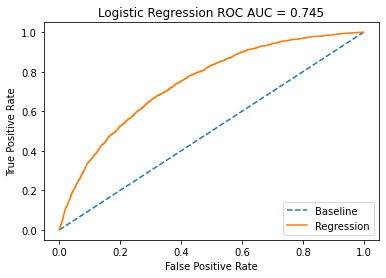

In [48]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

#predict_proba - Probability estimates.
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Без подбора гиперпараметров значение на kaggle получилось 0.745, что выше, чем обработка на платформе. 
#### Проверим оценки модели: 

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_predicted_test = model.predict(X_test)
print(f'test accuracy_score: {round(accuracy_score(y_test,Y_predicted_test),3)}')
print(f'test precision_score: {round(precision_score(y_test, Y_predicted_test),3)}')
print(f'test recall_score: {round(recall_score(y_test,Y_predicted_test),3)}')
print(f'test f1_score: {round(f1_score(y_test,Y_predicted_test),3)}')

test accuracy_score: 0.875
test precision_score: 0.413
test recall_score: 0.025
test f1_score: 0.046


In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_predicted_train = model.predict(X_train)
print(f'train accuracy_score: {round(accuracy_score(y_train,Y_predicted_train),3)}')
print(f'train precision_score: {round(precision_score(y_train,Y_predicted_train),3)}')
print(f'train recall_score: {round(recall_score(y_train,Y_predicted_train),3)}')
print(f'train f1_score: {round(f1_score(y_train,Y_predicted_train),3)}')

train accuracy_score: 0.872
train precision_score: 0.484
train recall_score: 0.03
train f1_score: 0.056


Судя по результатам, F1 совсем маленький, но при этом accuracy больше 0.87

### Попробуем добавить в модель гиперпараметры

In [51]:
from sklearn.model_selection import GridSearchCV
# Добавим типы регуляризации
penalty = ['l1', 'l2']
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее C: 1.0


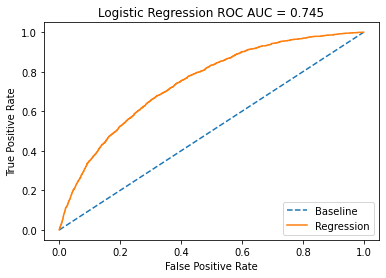

In [52]:
# Посчитаем новую модель: 
new_model = LogisticRegression(random_state=42, max_iter=1000, C=1, penalty = 'l1', solver = 'liblinear')
new_model.fit(X_train, y_train)

#predict_proba - Probability estimates.
probs = new_model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Как видим, с гиперпараметрами практически ничего не изменилось

In [53]:
best_Y_predicted_test = new_model.predict(X_test)
print(f'best test accuracy_score: {round(accuracy_score(y_test,best_Y_predicted_test),3)}')
print(f'best test precision_score: {round(precision_score(y_test,best_Y_predicted_test),3)}')
print(f'best test recall_score: {round(recall_score(y_test,best_Y_predicted_test),3)}')
print(f'best test f1_score: {round(f1_score(y_test,best_Y_predicted_test),3)}')

best test accuracy_score: 0.875
best test precision_score: 0.413
best test recall_score: 0.025
best test f1_score: 0.046


### Объединим тренировочную и тестовую выборки, посчитаем модель: 

Преобразуем тестовую выборку: 

In [54]:
# Для преобразования бинарных признаков используем LabelEncoder, 
# который переводит бинарные признаки в числовой формат

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()
# Для категориальных признаков мы будем использовать OneHotEncoder 
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
X_cat.shape

(110148, 30)

In [55]:
# попробуем стандартизировать числовые признаки в тренировочной выборке: 
X_num = StandardScaler().fit_transform(data[num_cols].values)

In [56]:
# Выделим тестовую выборку

data_test = data[data['train']==0]
X_num_test = X_num[73799:]
X_cat_test = X_cat[73799:]


In [57]:
X_num_test.shape

(36349, 5)

In [58]:
X_cat_test.shape

(36349, 30)

In [59]:
data_test[bin_cols].values.shape

(36349, 5)

In [60]:
data_test['default']

73799     0
73800     0
73801     0
73802     0
73803     0
         ..
110143    0
110144    0
110145    0
110146    0
110147    0
Name: default, Length: 36349, dtype: int64

In [61]:
X.shape

(73799, 40)

In [62]:
Y.shape

(73799,)

In [63]:
# Разделим выборку на тренировочную и тестовую: 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train = X
y_train = Y
X_test = np.hstack([X_num_test,data_test[bin_cols].values, X_cat_test])

In [64]:
# Посчитаем новую модель для всей выборки: 
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)

In [65]:
submit = pd.DataFrame(data_test['client_id'])

In [66]:
submit['default'] = y_pred
submit.to_csv('submission.csv', index=False)

In [67]:
submit.sample(10)

,client_id,default
81920,52306,0
83828,29610,0
109763,82047,0
109733,89224,0
94511,36292,0
90357,4005,0
80030,79117,0
77282,95064,0
98524,37684,1
96788,3368,0
